# Prediction of Air Canada Stock prices

In this project I am going to predict the next day stock price for Air Canada. I will use LSTM model for multivariate time series forecasting with the Keras backend.

Let's import neccesary packages

In [1]:
from __future__ import print_function
import IPython
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from data_utils import *
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


### Data Preparation

#### 1. parse date column

In [2]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

#### 2. Load data

In [3]:
df = pd.read_csv('AC.TO.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [4]:
df.head()

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2006-11-17,21.049999,21.049999,18.50,19.580000,19.580000,1324100.0
2006-11-20,19.500000,19.500000,18.40,18.750000,18.750000,476380.0
2006-11-21,18.750000,18.750000,17.50,17.860001,17.860001,1943962.0
2006-11-22,17.750000,19.129999,17.75,19.100000,19.100000,617710.0
2006-11-23,19.290001,19.490000,19.01,19.450001,19.450001,423204.0


In [5]:
df.describe()

,Open,High,Low,Close,Adj_close,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,12.091397,12.293455,11.874759,12.083844,12.083844,1.519023e+06
std,11.523337,11.691998,11.374855,11.535262,11.535262,2.003684e+06
min,0.780000,0.810000,0.730000,0.780000,0.780000,8.860000e+02
25%,2.340000,2.390000,2.290000,2.340000,2.340000,3.135032e+05
50%,9.265000,9.450000,9.075000,9.250000,9.250000,9.883865e+05
75%,17.007500,17.309999,16.750000,16.997500,16.997500,1.850825e+06
max,52.029999,52.709999,51.560001,52.090000,52.090000,2.715839e+07


In [6]:
print('First observation date: %s \nLast observation date: %s' % (df.index[0].date(), df.index[-1].date()))

First observation date: 2006-11-17 
Last observation date: 2020-11-30


In [7]:
df.isnull()

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2006-11-17,False,False,False,False,False,False
2006-11-20,False,False,False,False,False,False
2006-11-21,False,False,False,False,False,False
2006-11-22,False,False,False,False,False,False
2006-11-23,False,False,False,False,False,False
...,...,...,...,...,...,...
2020-11-24,False,False,False,False,False,False
2020-11-25,False,False,False,False,False,False
2020-11-26,False,False,False,False,False,False


In [8]:
print(np.var(np.subtract(df.Close, df.Adj_close)))

0.0


Since, there is no difference between close and Adj_close, we can romove one of either columns from analysis. 

In [9]:
df.drop(["Adj_close"], inplace=True, axis=1)

In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [11]:
group=[x for x in range(len(df.columns))]
print(group)

[0, 1, 2, 3, 4]


In [12]:
df.index[0:5]

DatetimeIndex(['2006-11-17', '2006-11-20', '2006-11-21', '2006-11-22',
               '2006-11-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

#### 3. Visualization of data

<function matplotlib.pyplot.show(close=None, block=None)>

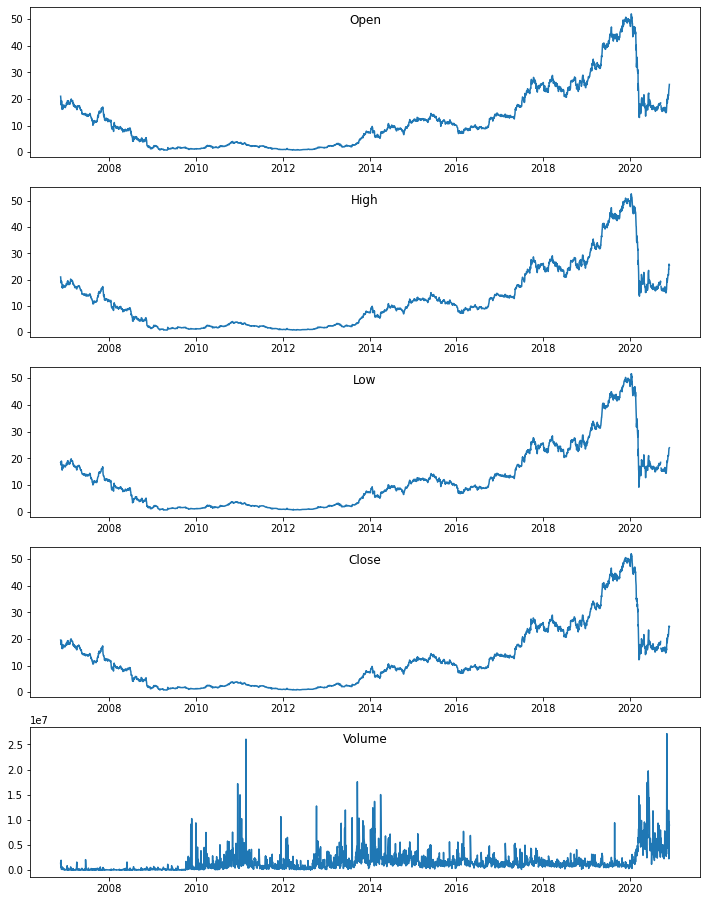

In [13]:
# Plot each column
groups=[x for x in range(len(df.columns))]
i=1
plt.figure(figsize = (12,16))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(df.index, df.values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show

In [14]:
for i, col_list in enumerate(df.columns):
    print(i, col_list)

0 Open
1 High
2 Low
3 Close
4 Volume


<function matplotlib.pyplot.show(close=None, block=None)>

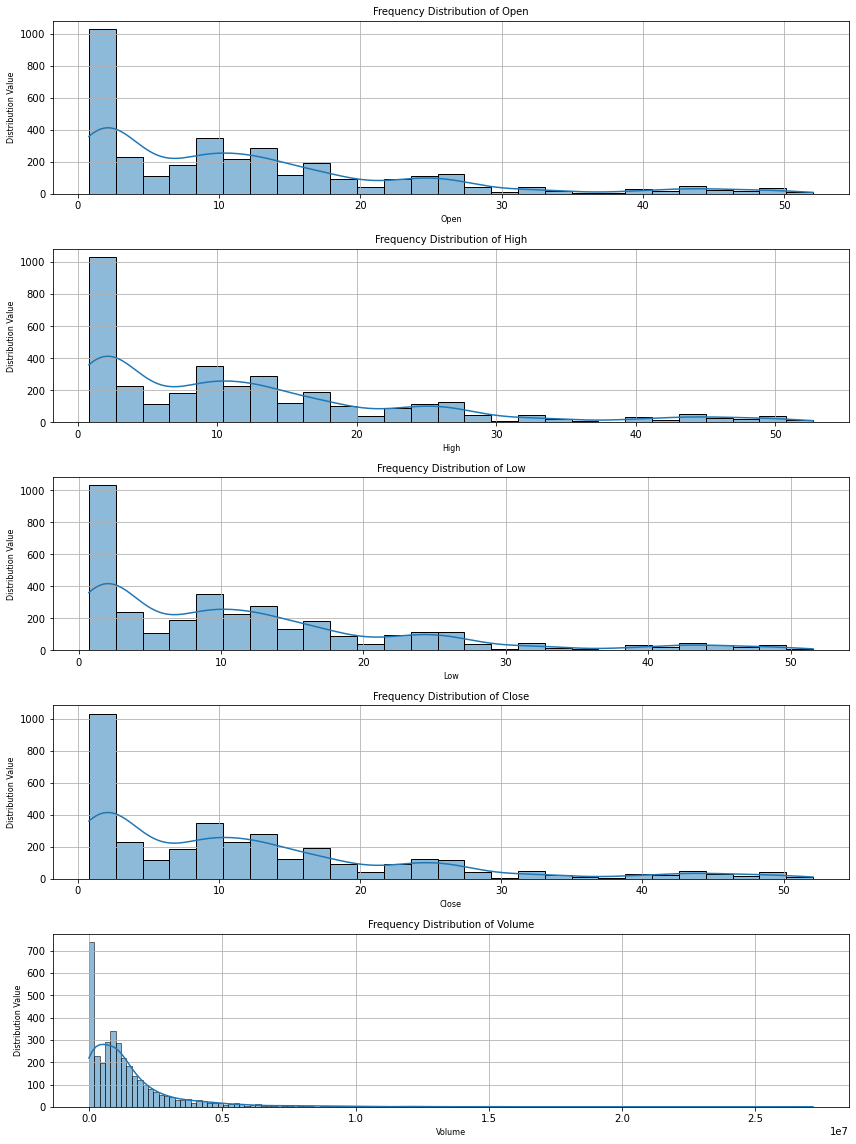

In [15]:
import seaborn as sns
fig, ax = plt.subplots(len(df.columns), figsize = (12,16))
for i, col_list in enumerate(df.columns):
    sns.histplot(df[col_list], ax =ax[i], kde= True)
    ax[i].set_title ("Frequency Distribution of" + " " + col_list, fontsize = 10)
    ax[i].set_xlabel (col_list, fontsize = 8)
    ax[i].set_ylabel ('Distribution Value', fontsize = 8)
    fig.tight_layout (pad = 1.1) # To provide space between plots
    ax[i].grid('on') # Enabled to view and make markings
plt.show

C:\Users\rwrhmudi\anaconda3\envs\deep\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\rwrhmudi\anaconda3\envs\deep\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\rwrhmudi\anaconda3\envs\deep\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWar

<function matplotlib.pyplot.show(close=None, block=None)>

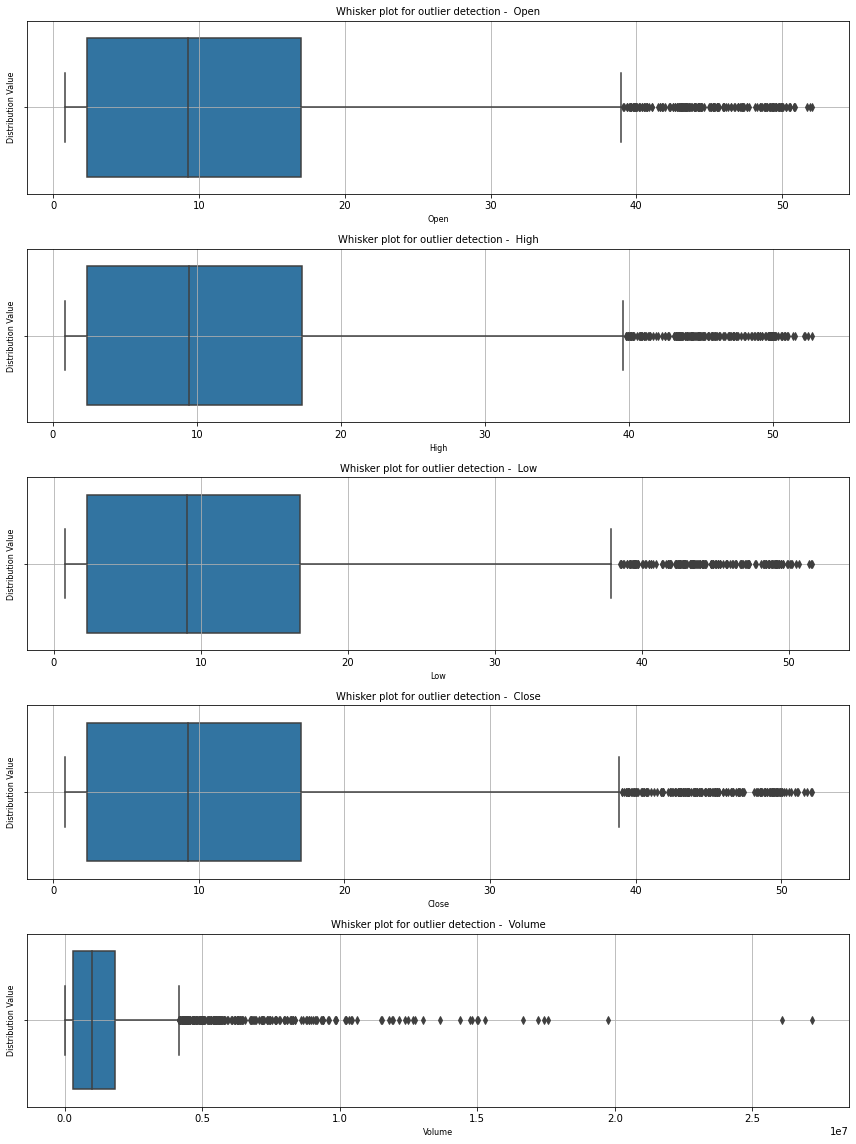

In [16]:
# Identifying the outliers
fig, ax = plt.subplots(len(df.columns), figsize = (12,16))
for i, col_list in enumerate(df.columns):
    sns.boxplot(df[col_list], ax =ax[i],  orient="h")
    ax[i].set_title ("Whisker plot for outlier detection - " + " " + col_list, fontsize = 10)
    ax[i].set_xlabel (col_list, fontsize = 8)
    ax[i].set_ylabel ('Distribution Value', fontsize = 8)
    fig.tight_layout (pad = 1.1) # To provide space between plots
    ax[i].grid('on') # Enabled to view and make markings
plt.show

#### 4. Data preperation

In [17]:
# convert series to supervised learning
def series_to_supervised(data, c_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in c_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['%s(t)' % (j) for j in c_names]
        else:
            names += ['%s(t+%d)' % (j, i) for j in c_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# let's get the column names
c_names = [name for name in df.columns]

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [20]:
n_days_back = 7
n_days_future = 1
n_features = len(df.columns)

# frame as supervised learning
reframed = series_to_supervised(scaled, c_names, n_days_back, n_days_future)
reframed.head()

,Open(t-7),High(t-7),Low(t-7),Close(t-7),Volume(t-7),Open(t-6),High(t-6),Low(t-6),Close(t-6),Volume(t-6),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
7,0.395512,0.389981,0.349597,0.366400,0.048724,0.365268,0.360116,0.347629,0.350224,0.017509,...,0.355512,0.351638,0.334842,0.331319,0.012642,0.338927,0.334104,0.315168,0.318456,0.007983
8,0.365268,0.360116,0.347629,0.350224,0.017509,0.350634,0.345665,0.329923,0.332879,0.071548,...,0.338927,0.334104,0.315168,0.318456,0.007983,0.318829,0.316763,0.305331,0.304424,0.009807
9,0.350634,0.345665,0.329923,0.332879,0.071548,0.331122,0.352987,0.334842,0.357045,0.022713,...,0.318829,0.316763,0.305331,0.304424,0.009807,0.299122,0.310983,0.293134,0.313194,0.022606
10,0.331122,0.352987,0.334842,0.357045,0.022713,0.361171,0.359923,0.359630,0.363867,0.015551,...,0.299122,0.310983,0.293134,0.313194,0.022606,0.316488,0.318690,0.310643,0.312025,0.004062
11,0.361171,0.359923,0.359630,0.363867,0.015551,0.363317,0.359152,0.359433,0.361333,0.004423,...,0.316488,0.318690,0.310643,0.312025,0.004062,0.319219,0.314644,0.307692,0.304424,0.005557


In [21]:
reframed.shape

(3508, 40)

In [22]:
n_obs = n_days_back * n_features

# Here, we pick the target variable column which is Open(t)
target_idx = [reframed.columns.get_loc(col) for col in reframed.columns[n_obs:] if 'Open' in col]
type(target_idx)

list

First, divide data into input features and target variable

In [23]:
values=reframed.values
y= values[:, target_idx]
X=values[:,0:target_idx[0]]
print("y shape is ", y.shape)
print("X shape is ", X.shape)

y shape is  (3508, 1)
X shape is  (3508, 35)


Let's split data into train and test set set

In [24]:
from sklearn.model_selection import train_test_split
# Let's split data into train and test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2806, 35) (2806, 1)
Test set: (702, 35) (702, 1)


In [25]:
# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
X_train = X_train.reshape((X_train.shape[0], n_days_back, n_features))
X_test = X_test.reshape((X_test.shape[0], n_days_back, n_features))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2806, 7, 5) (2806, 1) (702, 7, 5) (702, 1)


#### 5. Model

In [26]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [27]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

callback_list = [checkpoint]

model.compile(optimizer = 'adam', loss = root_mean_squared_error)

t = model.fit(X_train, y_train, epochs=50,
              batch_size=32,
              validation_data=(X_test, y_test),
              verbose=1,
              callbacks = callback_list,
              shuffle=False)

model.load_weights('w.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 1s 328us/step - loss: 0.0371 - val_loss: 0.0133
Epoch 2/50
2806/2806 [==============================] - 1s 179us/step - loss: 0.0129 - val_loss: 0.0106
Epoch 3/50
2806/2806 [==============================] - 1s 178us/step - loss: 0.0122 - val_loss: 0.0096
Epoch 4/50
2806/2806 [==============================] - 0s 171us/step - loss: 0.0112 - val_loss: 0.0086
Epoch 5/50
2806/2806 [==============================] - 0s 171us/step - loss: 0.0103 - val_loss: 0.0081
Epoch 6/50
2806/2806 [==============================] - 0s 170us/step - loss: 0.0097 - val_loss: 0.0070
Epoch 7/50
2806/2806 [==============================] - 0s 167us/step - loss: 0.0086 - val_loss: 0.0097
Epoch 8/50
2806/2806 [==============================] - 0s 165us/step - loss: 0.0086 - val_loss: 0.0095
Epoch 9/50
2806/2806 [====

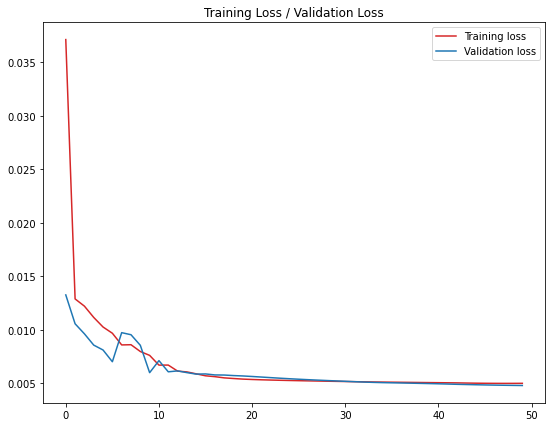

In [28]:
# plot training history
plt.figure(figsize = (9,7))
plt.title('Training Loss / Validation Loss')
plt.plot(t.history['loss'], 'tab:red', label='Training loss')
plt.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

In [29]:
import math
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(X_test)

# invert scaling
yhat_inv = yhat / scaler.scale_[0]
y_inv = y_test / scaler.scale_[0]

# reshape back
yhat_inv_rshp = yhat_inv.reshape((-1,1))
y_inv_rshp = y_inv.reshape((-1,1))

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_inv_rshp, yhat_inv_rshp))
print('Test set RMSE: %.2f' % rmse)

Test set RMSE: 0.28


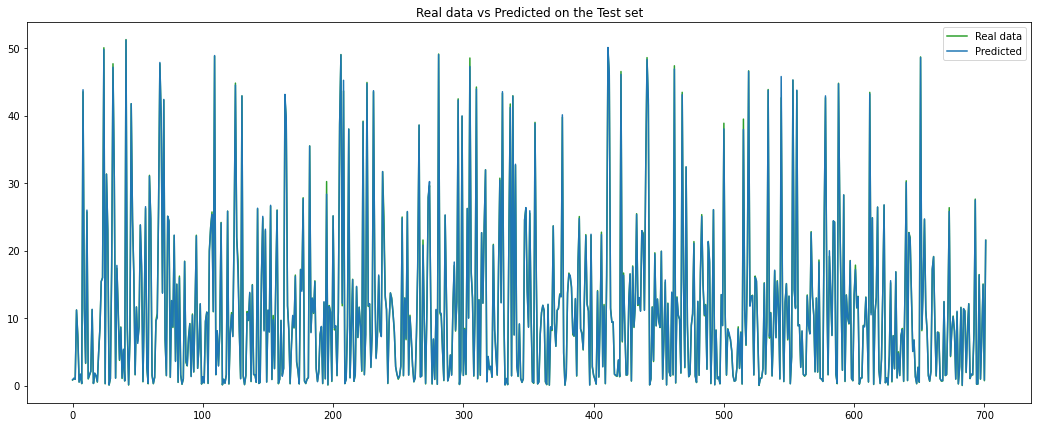

In [30]:
plt.figure(figsize = (18,7))
plt.title('Real data vs Predicted on the Test set')
plt.plot(y_inv_rshp, 'tab:green', label='Real data')
plt.plot(yhat_inv_rshp, 'tab:blue', label='Predicted')
plt.legend()
plt.show()

In [31]:
print(f'Initial set size: {df.shape[0]}')
print(f'Train set X size: {X_train.shape[0]}, train set y size: {y_train.shape[0]}')
print(f'Test set X size: {X_test.shape[0]}, test set y size: {y_test.shape[0]}')

Initial set size: 3523
Train set X size: 2806, train set y size: 2806
Test set X size: 702, test set y size: 702


In [32]:
reframed.tail(1)

,Open(t-7),High(t-7),Low(t-7),Close(t-7),Volume(t-7),Open(t-6),High(t-6),Low(t-6),Close(t-6),Volume(t-6),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
3522,0.40761,0.408285,0.400748,0.407328,0.237662,0.408195,0.407707,0.397797,0.39427,0.201,...,0.451317,0.484393,0.453866,0.469304,0.354188,0.482341,0.477649,0.456817,0.466186,0.330184


In [33]:
last_day = reframed.iloc[-1:, -n_obs:]
last_day = last_day.values
last_day = last_day.reshape((-1, n_days_back, n_features))

t_plus_one = model.predict(last_day)
t_plus_one /= scaler.scale_[0]
print('Last observation\'s date in the dateset is %s\nLast observation\'s value is %.2f' % (df.index[-1].date(), df.iloc[-1, 0]))
print('\nPredicted observation\'s date is %s\nPredicted observation\'s value is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), t_plus_one))
print('\nReal value for %s is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), 25.06))

Last observation's date in the dateset is 2020-11-30
Last observation's value is 25.50

Predicted observation's date is 2020-12-01
Predicted observation's value is 23.95

Real value for 2020-12-01 is 25.06


In [34]:
datetime.timedelta(days=1)

datetime.timedelta(1)